# Relativistic SGHMC (Banana function)

In what follows, we will fit relativistic stochastic gradient hamiltonian monte carlo to a banana cost function reproducing the results 
from [this notebook](https://github.com/xiaoyulu2014/RelHMC/blob/master/xiaoyu/examples/BananaExample.ipynb) of the original authors.



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join("..", "..", "..")))

from pysgmcmc.samplers.relativistic_sghmc import RelativisticSGHMCSampler
from pysgmcmc.diagnostics.objective_functions import banana_log_likelihood  # cost function for sampling

## Setting up our toolbox

Below we define two functions: one to plot the contours of our cost function and one to produce a final plot 
with samples drawn from a sampler on top of those contours.

In [2]:
def plot_contour(f, range_x, range_y):
    """
    Produce a contour plot of callable `f` evaluated on a grid
    of values with ranges `range_x` and `range_y`.

    Parameters
    ----------
    f : callable
        Callable of which we would like to plot the contours.

    range_x : tuple
        3-tuple (start, stop, step) that will be fed to `numpy.arange`
        to produce x-values for a grid.

    range_y : tuple
        3-tuple (start, stop, step) that will be fed to `numpy.arange`
        to produce y-values for a grid.
    """

    x = np.arange(*range_x)
    y = np.arange(*range_y)
    xx, yy = np.meshgrid(x, y, sparse=True)
    densities = np.asarray([np.exp(banana_log_likelihood((x, y))) for x in xx for y in yy])

    h = plt.contour(x, y, densities, 1, label="Banana")

def run(sampler, n_samples=1000, keep_every=10):
    """
    Produce a plot that plots `n_samples` extracted from `sampler`
    on top of the contours of the corresponding cost function.
    Keep every `keep_every`th sample only, so a total of
    `n_samples * keep_every` iterations of the `sampler` are performed.

    Parameters
    ----------
    sampler : `pysgmcmc.sampling.MCMCSampler` subclass
        Sampler object to evaluate.
        
    n_samples : int, optional
        Number of samples to extract from `sampler`.
        Defaults to `1000`.

    keep_every : int, optional
        Keep only every `keep_every`th sample for the final plot.
        Defaults to `10`.

    """
    from itertools import islice

    n_iterations = n_samples * keep_every
    samples = np.asarray([sample for sample, _ in islice(sampler, 0, n_iterations, keep_every)])
    
    plot_contour(sampler.cost_fun, (-5, 6, 0.05), (-1, 32, 0.05))    
    plt.scatter(samples[:,0], samples[:, 1])
    plt.show()

## Actual Experiment

Below we extract 1000 samples from our `RelativisticSGHMCSampler` and plot them 
over the contours of the banana function. 


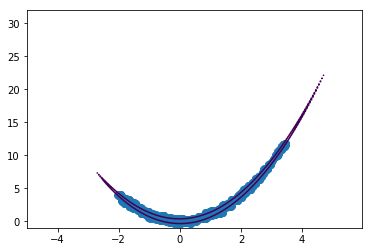

In [3]:
from pysgmcmc.samplers.relativistic_sghmc import RelativisticSGHMCSampler

params = [tf.Variable(0., dtype=tf.float64), tf.Variable(0., dtype=tf.float64)]

def banana_neg_log_likelihood(params):
    return -banana_log_likelihood(params)

with tf.Session() as session:
    s = RelativisticSGHMCSampler(
        epsilon=0.01,
        params=params, 
        cost_fun=banana_neg_log_likelihood, 
        session=session,
        dtype=tf.float64
    )
    session.run(tf.global_variables_initializer())
    run(s)